In [2]:
import pandas as pd
from textblob import TextBlob
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datasketch import MinHash, MinHashLSH
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import contractions
import pandas as pd
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community.quality import modularity


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
file_path = "../data/fake reviews dataset.csv"
df = pd.read_csv(file_path)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [3]:
unique_catgory = df['category'].unique()
print(unique_catgory)

['Home_and_Kitchen_5' 'Sports_and_Outdoors_5' 'Electronics_5'
 'Movies_and_TV_5' 'Tools_and_Home_Improvement_5' 'Pet_Supplies_5'
 'Kindle_Store_5' 'Books_5' 'Toys_and_Games_5'
 'Clothing_Shoes_and_Jewelry_5']


In [5]:
df = df.rename(columns={'text_':'text'})
df['category']=df['category'].str.replace('_5','',regex=False)

In [126]:
df.isnull().sum()

category    0
rating      0
label       0
text        0
dtype: int64

In [127]:
df.duplicated().sum()

12

In [5]:
df.drop_duplicates()

,category,rating,label,text
0,Home_and_Kitchen,5,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen,5,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen,5,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen,1,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen,5,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry,4,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry,5,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry,2,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry,1,CG,I liked nothing about this dress. The only rea...


In [6]:
df['label_binary'] = df['label'].replace({'CG': 1, 'OR': 0})

https://datastud.dev/posts/nlp-preprocess

In [7]:
df['processed_text']=(df['text']).apply(contractions.fix)
# Loop through each line of text and tokenize
df['processed_text'] = [word_tokenize(line) for line in df['processed_text']]

In [10]:
import string

def remove_punctuation(input_text):
    return [token for token in input_text if token not in set(string.punctuation)]

# Apply punctuation function
df['processed_text'] = [remove_punctuation(line) for line in df['processed_text']]

In [9]:
nltk.download('stopwords')

def remove_stopwords(input_text):
    return [token for token in input_text if token.lower() not in stopwords.words('english')]

# Apply stopword function
df['processed_text'] = [remove_stopwords(line) for line in df['processed_text']]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [133]:
df.head()

,category,rating,label,text,label_binary,processed_text
0,Home_and_Kitchen,5,CG,"Love this! Well made, sturdy, and very comfor...",1,"[Love, Well, made, sturdy, comfortable, love, ..."
1,Home_and_Kitchen,5,CG,"love it, a great upgrade from the original. I...",1,"[love, great, upgrade, original, mine, couple,..."
2,Home_and_Kitchen,5,CG,This pillow saved my back. I love the look and...,1,"[pillow, saved, back, love, look, feel, pillow]"
3,Home_and_Kitchen,1,CG,"Missing information on how to use it, but it i...",1,"[Missing, information, use, great, product, pr..."
4,Home_and_Kitchen,5,CG,Very nice set. Good quality. We have had the s...,1,"[nice, set, Good, quality, set, two, months]"


In [11]:
#lemmazation
def lemmatize(input_text):
    # Instantiate class
    lem = WordNetLemmatizer()
    # Lemmatized text becomes input inside all loop runs
    lemmatized_text = input_text
    # Lemmatize each part of speech
    for part_of_speech in ['n', 'v', 'a', 'r', 's']:
        lemmatized_text = [lem.lemmatize(token, part_of_speech).lower() for token in lemmatized_text]
    return lemmatized_text

# Apply lemmatize function
df['processed_text'] = [lemmatize(line) for line in df['processed_text']]

In [18]:
df.to_csv('../data/processed_data.csv', index=False, header=True)

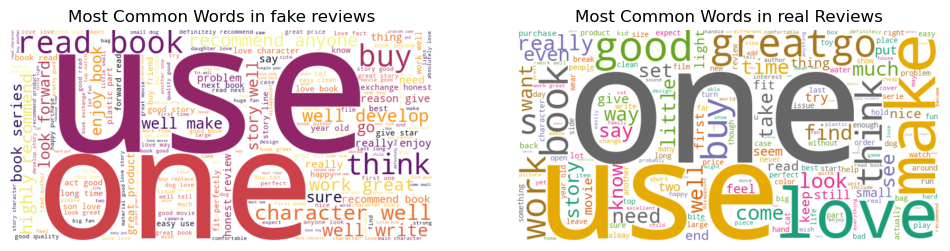

In [9]:
# Separate CG and OR reviews
cg_text = ' '.join([' '.join(words) for words in df[df['label'] == 'CG']['processed_text']])
or_text = ' '.join([' '.join(words) for words in df[df['label'] == 'OR']['processed_text']])

# Generate word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
cg_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='inferno').generate(cg_text)
plt.imshow(cg_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in fake reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
or_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').generate(or_text)
plt.imshow(or_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in real Reviews')
plt.axis('off')

plt.show()

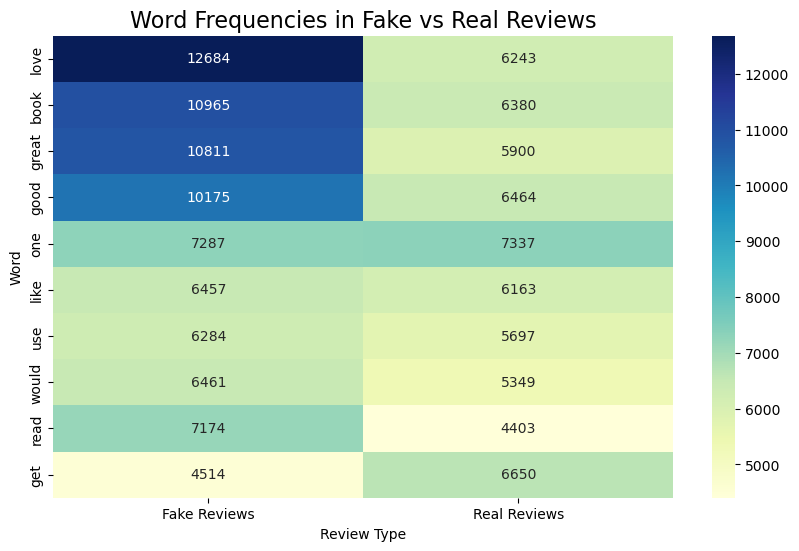

In [26]:
import seaborn as sns

# Count word frequencies for fake and real reviews
cg_word_counts = Counter(cg_text.split())
or_word_counts = Counter(or_text.split())

# Combine counts into a DataFrame
words = list(set(cg_word_counts.keys()).union(or_word_counts.keys()))
word_frequencies = pd.DataFrame({
    "Word": words,
    "Fake Reviews": [cg_word_counts.get(word, 0) for word in words],
    "Real Reviews": [or_word_counts.get(word, 0) for word in words]
}).set_index("Word")

# Select top words based on total frequency
top_words = word_frequencies.sum(axis=1).nlargest(10).index
heatmap_data = word_frequencies.loc[top_words]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Word Frequencies in Fake vs Real Reviews", fontsize=16)
plt.xlabel("Review Type")
plt.ylabel("Word")
plt.show()

In [28]:
# Count word frequencies for real reviews
or_word_counts = Counter(or_text.split())
top_words = list(set(cg_word_counts.keys()).union(or_word_counts.keys()))

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Word": top_words,
    "Fake Reviews": [cg_word_counts.get(word, 0) for word in top_words],
    "Real Reviews": [or_word_counts.get(word, 0) for word in top_words]
})

# Get the top 20 words by total frequency
comparison_df["Total"] = comparison_df["Fake Reviews"] + comparison_df["Real Reviews"]
top_comparison = comparison_df.nlargest(20, "Total")

# Melt DataFrame for Plotly Express
melted_df = top_comparison.melt(id_vars=["Word"], value_vars=["Fake Reviews", "Real Reviews"], var_name="Review Type", value_name="Frequency")

# Create side-by-side bar chart
fig = px.bar(
    melted_df,
    x="Word",
    y="Frequency",
    color="Review Type",
    barmode="group",
    title="Top Words: Fake vs Real Reviews",
    labels={"Word": "Word", "Frequency": "Frequency", "Review Type": "Type"}
)
fig.update_layout(title_font_size=18, xaxis_tickangle=45)
fig.show()

/Users/vedisingvars/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/vedisingvars/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [136]:
label_counts = df['label'].value_counts(normalize=True).reset_index()
label_counts.columns = ['label', 'proportion']

# Plot the proportions
fig = px.bar(label_counts, x='label', y='proportion', title='Count of OR and CG reviews',
             labels={'label': 'Label', 'proportion': 'Proportion'},
             color='label', color_discrete_sequence=['skyblue', 'salmon'])

fig.show()

/Users/vedisingvars/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/vedisingvars/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



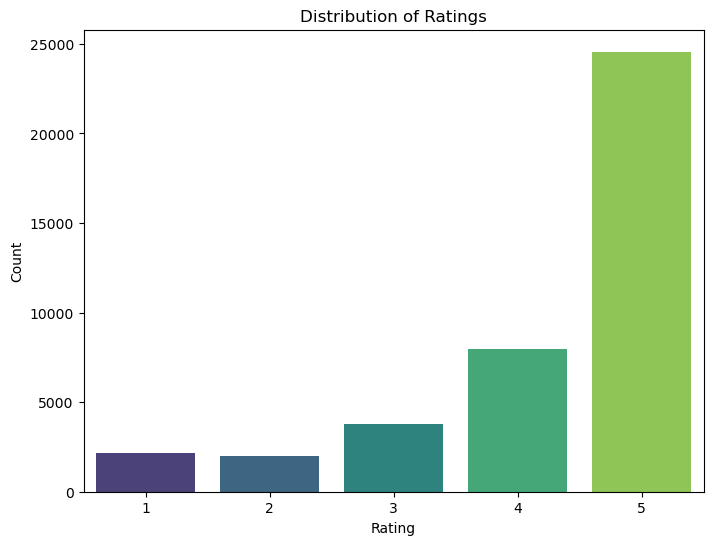

In [137]:

# Plot distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

/var/folders/9w/dgxmbyyn2hl1p64rjgpmgw880000gn/T/ipykernel_12895/1687703350.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




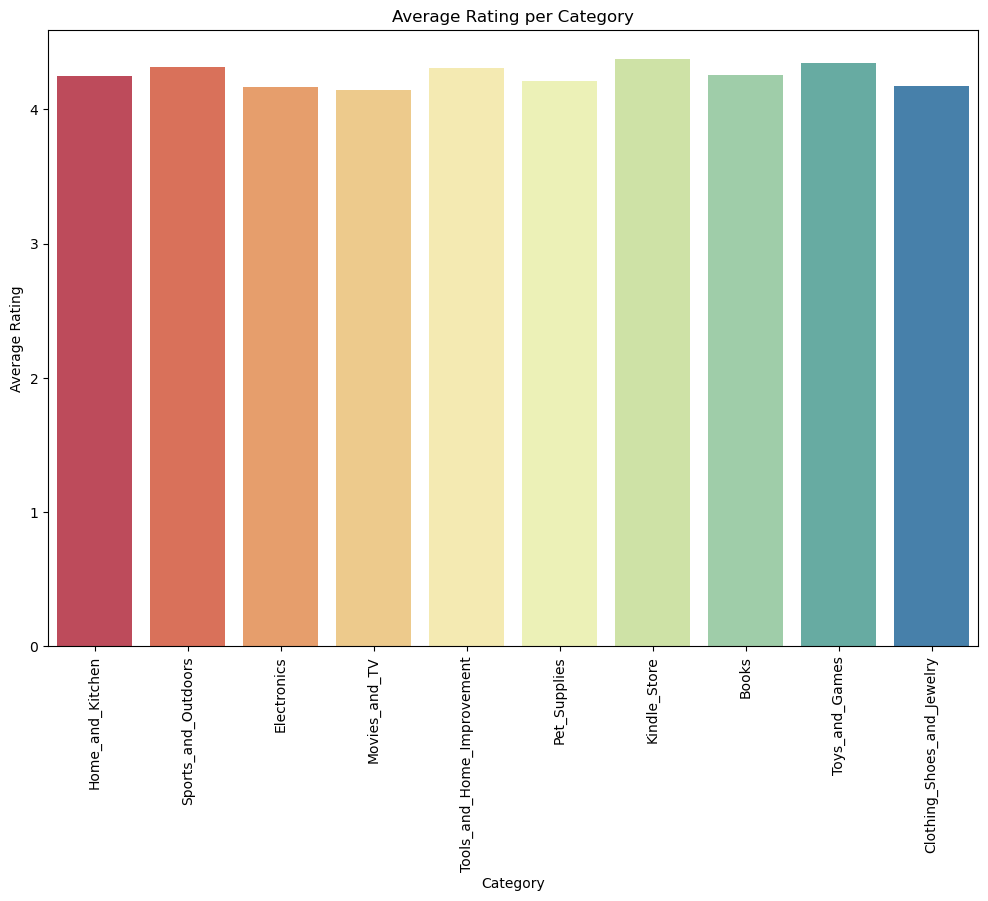

In [72]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='category', y='rating', estimator='mean', ci=None, palette='Spectral')
plt.xticks(rotation=90)
plt.title('Average Rating per Category')
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.show()

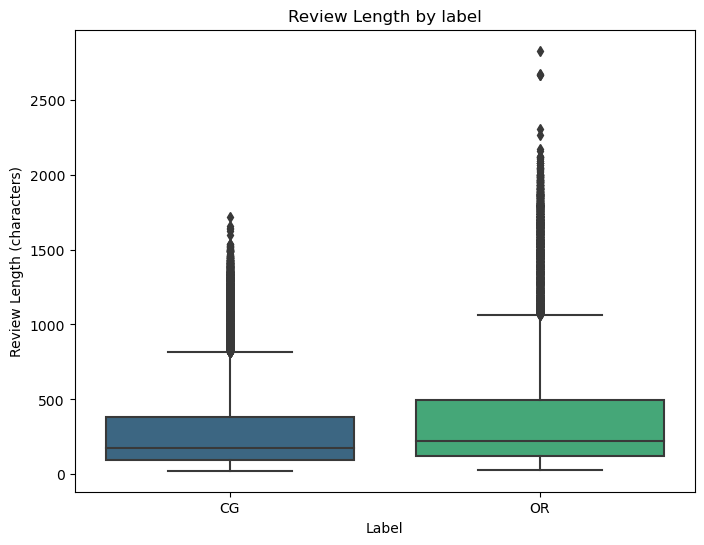

In [73]:
# Add a column for review length
df['review_length'] = df['text'].apply(len)

# Plot review length by rating
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='label', y='review_length', palette='viridis')
plt.title('Review Length by label')
plt.xlabel('Label')
plt.ylabel('Review Length (characters)')
plt.show()

In [138]:
# Count the occurrences of each category
category_counts = df['category'].value_counts()

# Display the category with the most reviews
most_reviews_category = category_counts.idxmax()
most_reviews_count = category_counts.max()

print(f"Category with the most reviews: {most_reviews_category} ({most_reviews_count} reviews)")

Category with the most reviews: Kindle_Store (4730 reviews)


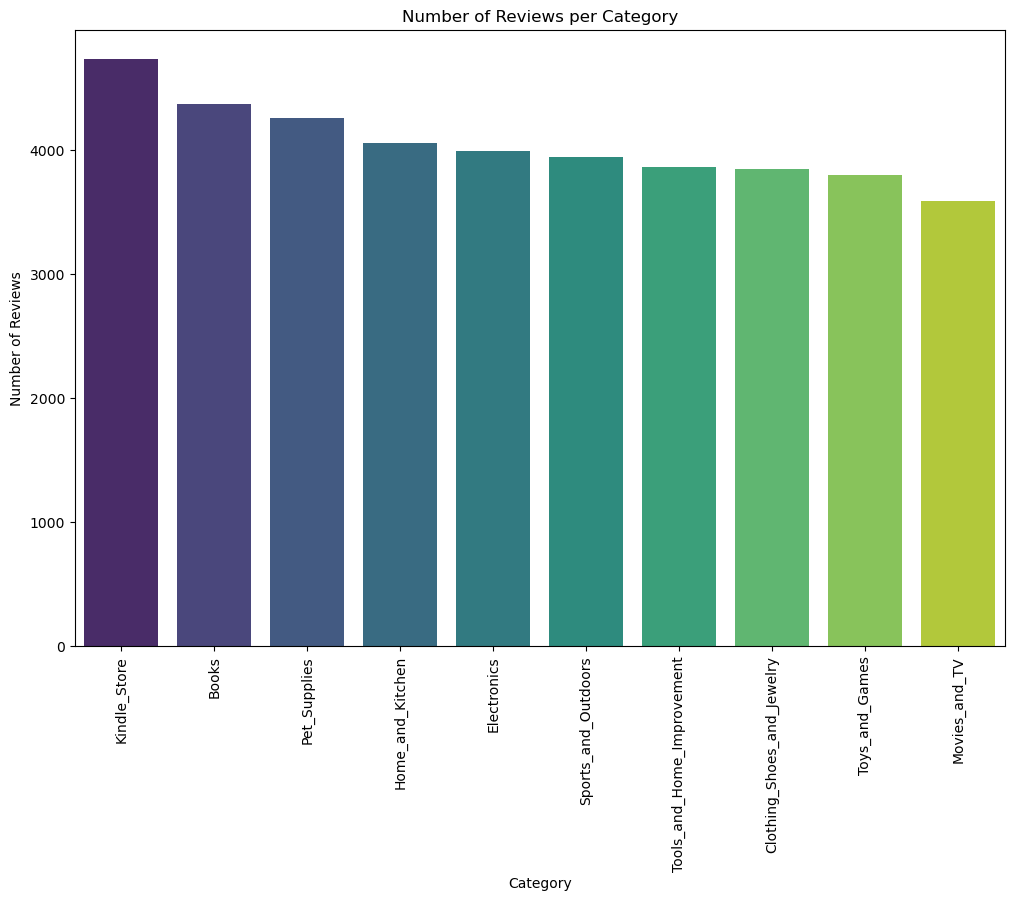

In [17]:
# Plot the number of reviews per category
plt.figure(figsize=(12, 8))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Number of Reviews per Category')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.show()

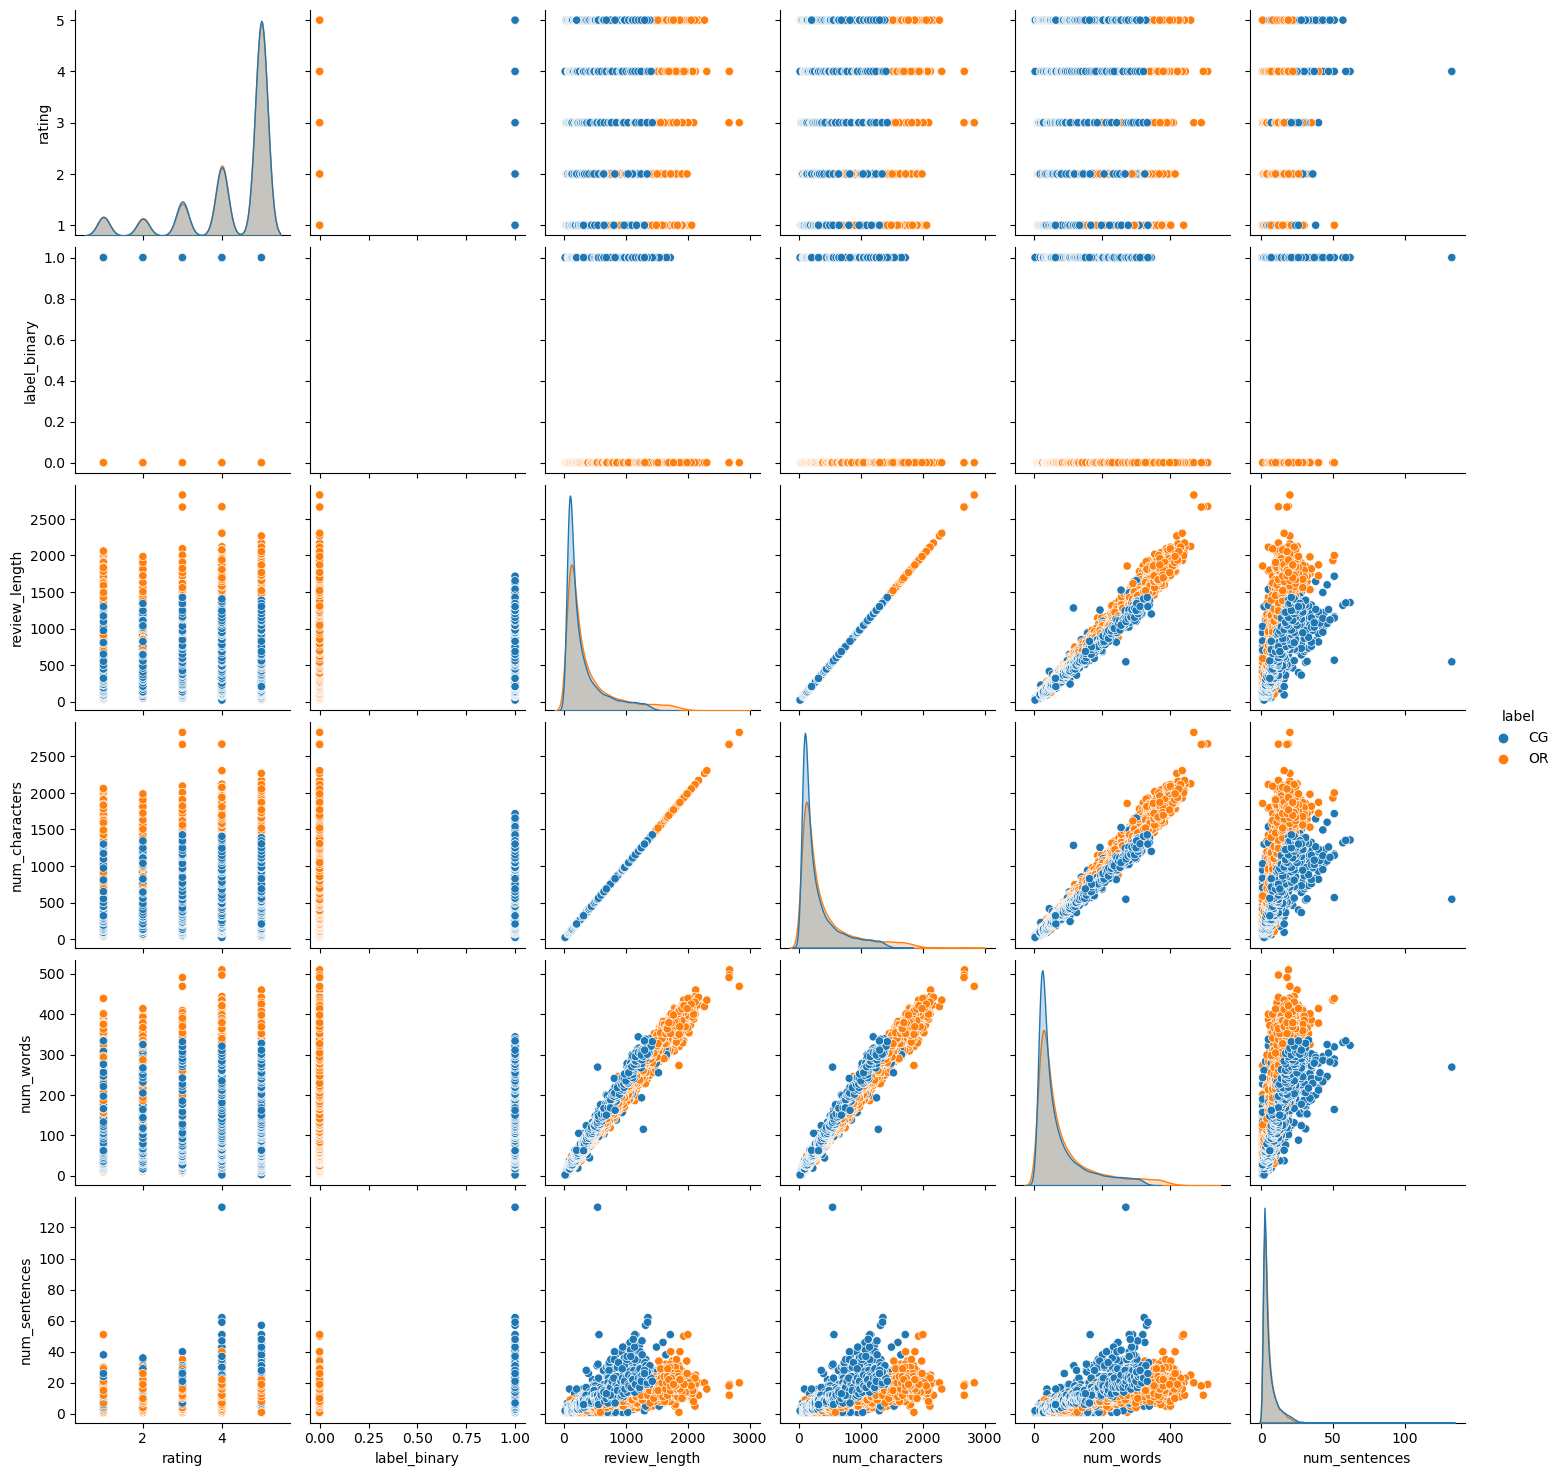

In [20]:
sns.pairplot(df,hue='label')

## Graph clustering algorithms (betweenness centrality, spectral clustering, Louvain algorithm) and evaluation measures (e.g. modularity)

In [12]:
# Text preprocessing and TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['processed_text'].apply(' '.join))

# Compute similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

In [13]:
# Threshold for similarity to create edges in the graph
threshold = 0.5

# Create a graph
G = nx.Graph()

# Add nodes (each review is a node)
for i, review in enumerate(df['processed_text']):
    G.add_node(i, category=df['category'][i], label=df['label'][i], rating=df['rating'][i])

# Add edges based on similarity
for i in range(similarity_matrix.shape[0]):
    for j in range(i + 1, similarity_matrix.shape[1]):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

# Print graph summary
print(f"Graph Summary:\nNodes: {G.number_of_nodes()}\nEdges: {G.number_of_edges()}\nIs Directed: {nx.is_directed(G)}")

Graph Summary:
Nodes: 40432
Edges: 335842
Is Directed: False


Nodes: 40,432
This is the total number of distinct entities in your graph. In your case, each review (or reviewer, depending on how you constructed the graph) is represented as a node.

Edges: 335,842
These are the connections or relationships between the nodes.
In your case, an edge is created based on similarity between reviews (e.g., text similarity or shared attributes like category or reviewer).

s Directed: False
This indicates your graph is undirected, meaning the edges between nodes have no direction.
Example: If a similarity exists between Review A and Review B, it is treated as a mutual relationship, i.e., A is connected to B, and B is connected to A.

In [12]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Find the node with the highest degree centrality
root = max(degree_centrality, key=degree_centrality.get)
print(f"Selected Root Node: {root} with Degree Centrality: {degree_centrality[root]}")

Selected Root Node: 28378 with Degree Centrality: 0.02639064084489624


In [13]:
def step1(G, root):
    """
       Perform Breadth-First Search to get all shortest paths from the root in given graph G
       G: networkx graph
       root: node from G to consider as root
    """
    # List to keep track of visited nodes
    visited, queue = [], []
    # Initialize shortest paths
    shortest_paths_dict = {}
    
    visited.append(root)
    queue.append((root, [root]))

    while queue:
        s, path = queue.pop(0)

        for neighbour in list(G.neighbors(s)):
            if neighbour != root:
                new_path = path + [neighbour]
                if neighbour not in visited:
                    visited.append(neighbour)
                    queue.append((neighbour, new_path))
                    shortest_paths_dict[neighbour] = [new_path]
                else:
                    if len(new_path) == len(shortest_paths_dict[neighbour][0]):
                        shortest_paths_dict[neighbour].append(new_path)

    return shortest_paths_dict

ex_shortest_paths_dict = step1(G, 28378)
ex_shortest_paths_dict

{23690: [[28378, 23690]],
 23718: [[28378, 23718]],
 23741: [[28378, 23741]],
 23785: [[28378, 23785]],
 23796: [[28378, 23796]],
 23799: [[28378, 23799]],
 23868: [[28378, 23868]],
 23870: [[28378, 23870]],
 23879: [[28378, 23879]],
 23923: [[28378, 23923]],
 23933: [[28378, 23933]],
 23955: [[28378, 23955]],
 23960: [[28378, 23960]],
 23970: [[28378, 23970]],
 23996: [[28378, 23996]],
 24049: [[28378, 24049]],
 24070: [[28378, 24070]],
 24089: [[28378, 24089]],
 24117: [[28378, 24117]],
 24118: [[28378, 24118]],
 24164: [[28378, 24164]],
 24168: [[28378, 24168]],
 24258: [[28378, 24258]],
 24259: [[28378, 24259]],
 24262: [[28378, 24262]],
 24342: [[28378, 24342]],
 24350: [[28378, 24350]],
 24367: [[28378, 24367]],
 24370: [[28378, 24370]],
 24381: [[28378, 24381]],
 24395: [[28378, 24395]],
 24438: [[28378, 24438]],
 24439: [[28378, 24439]],
 24441: [[28378, 24441]],
 24453: [[28378, 24453]],
 24462: [[28378, 24462]],
 24465: [[28378, 24465]],
 24469: [[28378, 24469]],
 24471: [[28

In [14]:
def step2(G, shortest_paths_dict):
    l2 = {}
    for v in list(G.nodes()):
        if v in list(shortest_paths_dict.keys()):
            l2[v] = len(shortest_paths_dict[v])
        else:
            l2[v]=0
    return l2

ex_l2 = step2(G, ex_shortest_paths_dict)
ex_l2

{0: 2,
 1: 0,
 2: 5,
 3: 1,
 4: 2,
 5: 2,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 1,
 11: 0,
 12: 0,
 13: 1,
 14: 1,
 15: 0,
 16: 0,
 17: 1,
 18: 2,
 19: 2,
 20: 0,
 21: 1,
 22: 1,
 23: 4,
 24: 1,
 25: 0,
 26: 1,
 27: 0,
 28: 2,
 29: 0,
 30: 1,
 31: 1,
 32: 1,
 33: 0,
 34: 1,
 35: 1,
 36: 2,
 37: 3,
 38: 0,
 39: 0,
 40: 1,
 41: 0,
 42: 0,
 43: 1,
 44: 1,
 45: 0,
 46: 1,
 47: 0,
 48: 3,
 49: 1,
 50: 2,
 51: 1,
 52: 0,
 53: 5,
 54: 0,
 55: 2,
 56: 1,
 57: 1,
 58: 0,
 59: 3,
 60: 0,
 61: 2,
 62: 0,
 63: 0,
 64: 0,
 65: 1,
 66: 0,
 67: 1,
 68: 0,
 69: 0,
 70: 4,
 71: 1,
 72: 7,
 73: 1,
 74: 0,
 75: 7,
 76: 0,
 77: 1,
 78: 0,
 79: 2,
 80: 1,
 81: 2,
 82: 2,
 83: 1,
 84: 1,
 85: 0,
 86: 0,
 87: 1,
 88: 1,
 89: 2,
 90: 2,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 2,
 97: 0,
 98: 2,
 99: 1,
 100: 2,
 101: 0,
 102: 0,
 103: 1,
 104: 1,
 105: 0,
 106: 0,
 107: 0,
 108: 1,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 1,
 114: 1,
 115: 0,
 116: 5,
 117: 0,
 118: 1,
 119: 0,
 120: 9,
 121: 1,
 122: 32,
 1

In [15]:
def find_shortest_r2y_paths_using_e(all_paths, e):
    result = []
    start, end = e
    for aPath in all_paths:
        one_way = ''.join([str(a) for a in [start, end]]) in ''.join([str(a) for a in aPath])
        reverse_way = ''.join([str(a) for a in [end, start]]) in ''.join([str(a) for a in aPath])
        if one_way or reverse_way:
            result.append(aPath)
    return result


In [16]:
def step3(G, shortest_paths_dict, l2):
    b_r = []
    for start_node, end_node in list(G.edges()):
        list_to_sum = []
        for y in list(G.nodes()):
            if y in list(shortest_paths_dict.keys()):
                all_shortest_r2y_paths = shortest_paths_dict[y]
                all_shortest_r2y_using_e = find_shortest_r2y_paths_using_e(all_shortest_r2y_paths, [start_node, end_node])
                list_to_sum.append(len(all_shortest_r2y_using_e)/len(all_shortest_r2y_paths))
                # print((start_node, end_node), y, all_shortest_r2y_paths,all_shortest_r2y_using_e, list_to_sum)
        b_r.append([[start_node, end_node], sum(list_to_sum)])
    return b_r

In [ ]:
# compute final betweeness
def edge_betweeness(G, e):
    start, end = e
    to_sum = []
    for r in list(G.nodes()):
        # step 1
        shortest_paths_dict = step1(G, r)
        # step  2
        l2 = step2(G, shortest_paths_dict)
        # step 3
        b_r = step3(G, shortest_paths_dict, l2)
        for edge_list, score in b_r:
            if (edge_list == [start, end]) or (edge_list == [end, start]):
                to_sum.append(score)
    return 0.5 * sum(to_sum)

In [ ]:
def all_edge_betweeness(G):
    result = []
    for start, end in list(G.edges()):
        aScore = edge_betweeness(G, [start, end])
        result.append([
            [start, end],
            aScore
        ])
    return result

In [15]:
# Compute betweenness centrality
centrality = nx.betweenness_centrality(G, weight='weight')

# Sort nodes by centrality
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
print("Top nodes by betweenness centrality:", sorted_centrality[:5])

# Add centrality as a node attribute
nx.set_node_attributes(G, centrality, 'betweenness_centrality')

KeyboardInterrupt: 

## Frequent items: apriori

In [139]:
baskets = df['processed_text'].apply(lambda x: list(set(x)))

te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df_te = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori to find frequent itemsets
frequent_itemsets = apriori(df_te, min_support=0.05, use_colnames=True)
print(frequent_itemsets)

      support                 itemsets
0    0.086441                     ('')
1    0.082608                     ('s)
2    0.065344                     (``)
3    0.118520                   (also)
4    0.053423                 (anyone)
..        ...                      ...
162  0.061313             (would, use)
163  0.050084             (well, work)
164  0.061709            (would, well)
165  0.050183  (book, character, read)
166  0.053596      (book, story, read)

[167 rows x 2 columns]


## LOUVAIN METHOD

In [20]:
partition = community_louvain.best_partition(G)

In [22]:
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size = 40,
                       cmap = cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

KeyboardInterrupt: 

ANOTHER ONE

Modularity for Louvain: 0.5884849582006318


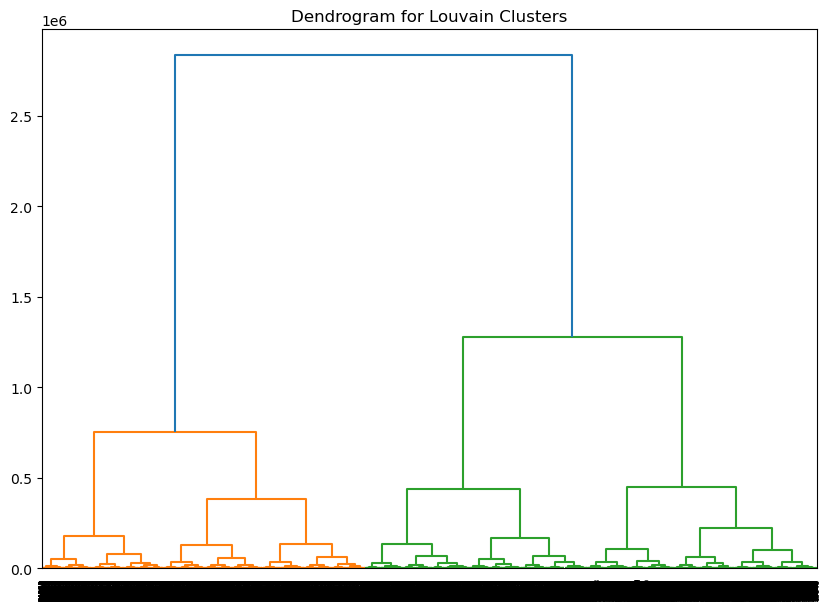

In [14]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np


# Apply the Louvain algorithm from NetworkX
louvain_comm = louvain_communities(G, seed=42)

# Compute modularity for Louvain clusters
louvain_modularity = modularity(G, louvain_comm)
print(f"Modularity for Louvain: {louvain_modularity}")

# Prepare clusters for the dendrogram
louvain_clusters = [list(community) for community in louvain_comm]
flat_clusters = np.concatenate(louvain_clusters)

# Ensure all items in flat_clusters are converted to floats and print correspondence
flat_clusters_float = []
for item in flat_clusters:
    if isinstance(item, (np.int32, np.float32, np.int64, np.float64)):
        flat_clusters_float.append(int(item))
        # print(f"Original: {item} -> Transformed: {float(item)}")
    else:
        transformed_value = int(ord(item) - ord('A'))
        flat_clusters_float.append(transformed_value)
        print(f"Original: {item} -> Transformed: {transformed_value} (ASCII code)")

flat_clusters_float = np.array(flat_clusters_float)

# Create a linkage matrix for the dendrogram
Z = linkage(flat_clusters_float.reshape(-1, 1), 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrogram for Louvain Clusters")
plt.show()

## SPECTRAL CLUSTERING

In [ ]:
import numpy as np
from sklearn.cluster import SpectralClustering

In [ ]:
adj_matrix = nx.to_numpy_array(G) 

## Similar Items/Locality-Sensitive Hashing (LSH)

In [140]:
# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['processed_text'].apply(' '.join))

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer
from datasketch import MinHash, MinHashLSH

In [142]:
# Initialize LSH for near-duplicate detection
lsh = MinHashLSH(threshold=0.8, num_perm=128)

# Add each review as a MinHash
for i, review in enumerate(tfidf_matrix):
    m = MinHash(num_perm=128)
    for word in review.nonzero()[1]:  # Get non-zero indices for each TF-IDF vector
        m.update(str(word).encode('utf8'))
    lsh.insert(i, m)

# Query for similar items for a particular review (e.g., index 0)
similar_reviews = lsh.query(m)
print(f"Reviews similar to review 0: {similar_reviews}")

Reviews similar to review 0: [40431]


## Clustering

In [143]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Use TF-IDF vectors for clustering
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['processed_text'].apply(' '.join))


# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Evaluate clustering
score = davies_bouldin_score(tfidf_matrix.toarray(), df['cluster'])
print(f"Davies-Bouldin Index: {score}")

# Check cluster composition
cluster_counts = df.groupby(['cluster', 'label']).size().unstack()
print(cluster_counts)


Davies-Bouldin Index: 6.3724780282682
label      CG     OR
cluster             
0        1252    670
1        2233   1547
2        9737  13510
3        3568   2456
4        3426   2033


A Davies-Bouldin Index (DBI) over 6 suggests that the clusters are likely overlapping significantly and not well-separated. This high score generally indicates that the clustering is of poor quality, and the clusters may not be capturing distinct groups effectively. Here are some strategies you could try to improve clustering quality - so lets try silhouette score to see if we should choose other number of k's

In [117]:
from sklearn.metrics import silhouette_score

# Try different values of k and calculate DBI and silhouette score
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(tfidf_matrix)
    dbi = davies_bouldin_score(tfidf_matrix.toarray(), labels)
    silhouette_avg = silhouette_score(tfidf_matrix, labels)
    print(f'For k={k}, DBI={dbi:.2f}, Silhouette Score={silhouette_avg:.2f}')

For k=2, DBI=4.78, Silhouette Score=0.01
For k=3, DBI=7.88, Silhouette Score=0.01
For k=4, DBI=5.94, Silhouette Score=0.02
For k=5, DBI=6.37, Silhouette Score=0.02
For k=6, DBI=7.14, Silhouette Score=0.02
For k=7, DBI=7.23, Silhouette Score=0.02
For k=8, DBI=6.54, Silhouette Score=0.02
For k=9, DBI=6.56, Silhouette Score=0.02


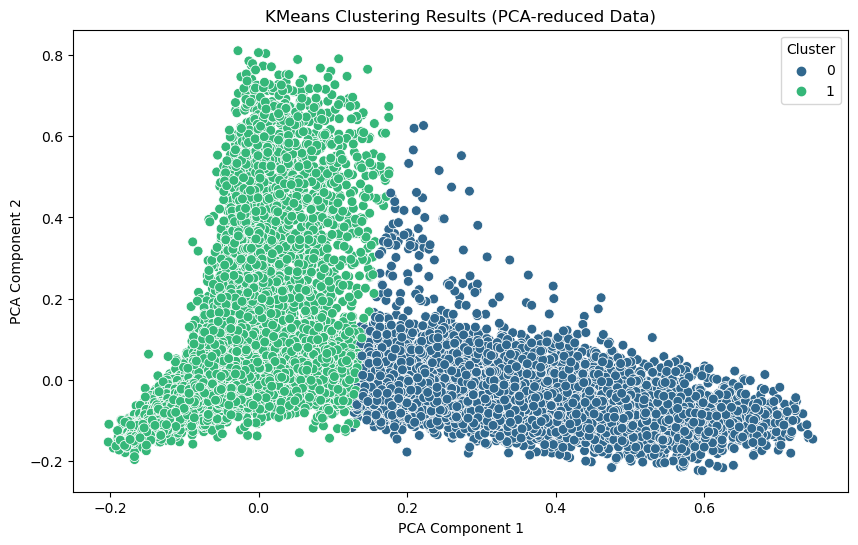

In [120]:
# Perform PCA to reduce the dimensions to 2 components for visualization
pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['cluster'], palette="viridis", s=50)
plt.title("KMeans Clustering Results (PCA-reduced Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()

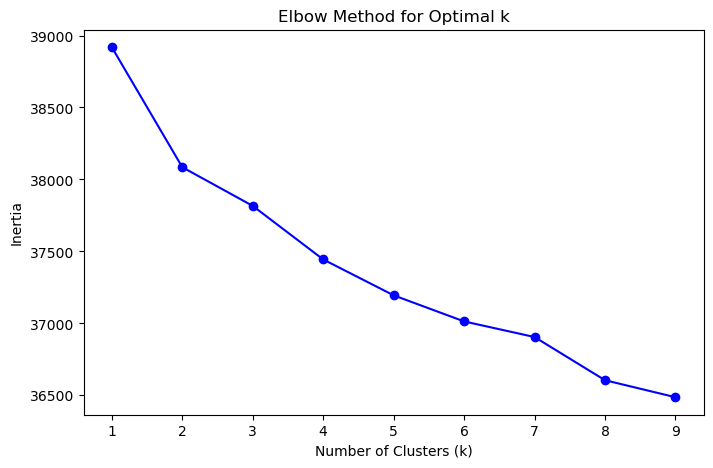

In [121]:
inertia = []
k_values = range(1, 10)

# Calculate inertia for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_values)
plt.show()

In [32]:
df.head(
)

,category,rating,label,text,label_binary,review_length,num_characters,num_words,num_sentences,processed_text
0,Home_and_Kitchen,5.0,CG,"Love this! Well made, sturdy, and very comfor...",1,75,75,18,3,love this well made sturdy and very comfortab...
1,Home_and_Kitchen,5.0,CG,"love it, a great upgrade from the original. I...",1,80,80,19,2,love it a great upgrade from the original ive...
2,Home_and_Kitchen,5.0,CG,This pillow saved my back. I love the look and...,1,67,67,16,2,this pillow saved my back i love the look and ...
3,Home_and_Kitchen,1.0,CG,"Missing information on how to use it, but it i...",1,81,81,19,2,missing information on how to use it but it is...
4,Home_and_Kitchen,5.0,CG,Very nice set. Good quality. We have had the s...,1,85,85,20,3,very nice set good quality we have had the set...


In [34]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Limit features for simplicity
tfidf_matrix = vectorizer.fit_transform(df['processed_text'])

In [35]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

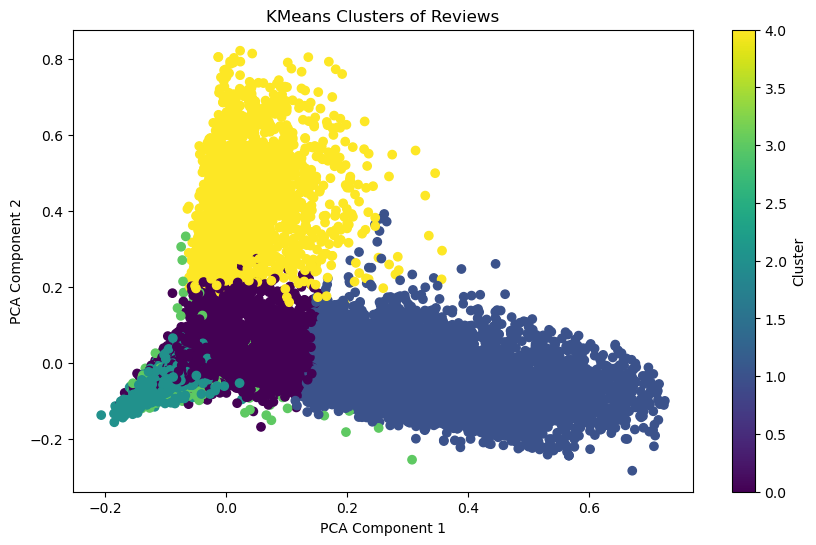

In [36]:
pca = PCA(n_components=2)
reduced_tfidf = pca.fit_transform(tfidf_matrix.toarray())
plt.figure(figsize=(10, 6))
plt.scatter(reduced_tfidf[:, 0], reduced_tfidf[:, 1], c=df['cluster'], cmap='viridis', marker='o')
plt.title('KMeans Clusters of Reviews')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()